In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({
    "figure.dpi": 130,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})


In [2]:
EVAL_DIR = Path("../data/processed/evaluation")

VAR_SUMMARY_PATH = EVAL_DIR / "var_backtesting_summary.csv"
ES_SUMMARY_PATH = EVAL_DIR / "es_empirical_summary.csv"
PLOT95_PATH = EVAL_DIR / "plot_source_95.csv"
BASE_TAIL95_PATH = EVAL_DIR / "baseline_tail_95.csv"
SENT_TAIL95_PATH = EVAL_DIR / "sentiment_tail_95.csv"

required = [VAR_SUMMARY_PATH, ES_SUMMARY_PATH, PLOT95_PATH, BASE_TAIL95_PATH, SENT_TAIL95_PATH]
missing = [str(p) for p in required if not p.exists()]
if missing:
    raise FileNotFoundError(
        "Missing evaluation artifacts. Run 03_evaluation_tests.ipynb first. Missing:\n"
        + "\n".join(missing)
    )


In [3]:
table_var_summary = pd.read_csv(VAR_SUMMARY_PATH)
table_es_summary = pd.read_csv(ES_SUMMARY_PATH)
plot_df = pd.read_csv(PLOT95_PATH, parse_dates=["Date"])
tail_b95 = pd.read_csv(BASE_TAIL95_PATH)
tail_s95 = pd.read_csv(SENT_TAIL95_PATH)


In [4]:
# Table 1 — VaR Backtesting Summary (thesis-formatted)
table_var_thesis = table_var_summary.copy()
table_var_thesis["Violation rate"] = (table_var_thesis["Violation rate"].astype(float) * 100).map(lambda x: f"{x:.2f}%")
table_var_thesis["Expected rate"] = (table_var_thesis["Expected rate"].astype(float) * 100).map(lambda x: f"{x:.2f}%")
table_var_thesis = table_var_thesis[
    ["Model", "Confidence", "Observations", "Violations", "Violation rate", "Expected rate"]
]

print("Table 1. VaR Backtesting Summary")
print(table_var_thesis.to_string(index=False))


Table 1. VaR Backtesting Summary
    Model Confidence  Observations  Violations Violation rate Expected rate
 Baseline        95%          1522         101          6.64%         5.00%
 Baseline        99%          1522          16          1.05%         1.00%
Sentiment        95%          1533         120          7.83%         5.00%
Sentiment        99%          1533          19          1.24%         1.00%


In [5]:
# Table 2 — Empirical ES Evaluation Summary (thesis-formatted)
table_es_thesis = table_es_summary.copy()
for c in [
    "Realized tail mean",
    "Predicted ES mean (violations)",
    "Tail mean gap (ES_pred - realized)",
    "ES Bias", "ES MAE", "ES RMSE"
]:
    table_es_thesis[c] = table_es_thesis[c].map(lambda x: f"{x:.6f}" if pd.notna(x) else "NA")

print("Table 2. Empirical ES Evaluation Summary")
print(table_es_thesis.to_string(index=False))


Table 2. Empirical ES Evaluation Summary
    Model Confidence  Observations  Violations  Violation rate Realized tail mean Predicted ES mean (violations) Tail mean gap (ES_pred - realized)   ES Bias   ES MAE  ES RMSE
 Baseline        95%          1522         101        0.066360          -0.026262                      -0.027861                          -0.001598 -0.001598 0.008643 0.016601
 Baseline        99%          1522          16        0.010512          -0.050760                      -0.058280                          -0.007519 -0.007519 0.012971 0.016545
Sentiment        95%          1533         120        0.078278          -0.024570                      -0.025258                          -0.000689 -0.000689 0.008222 0.014203
Sentiment        99%          1533          19        0.012394          -0.046428                      -0.045471                           0.000957  0.000957 0.011725 0.017223


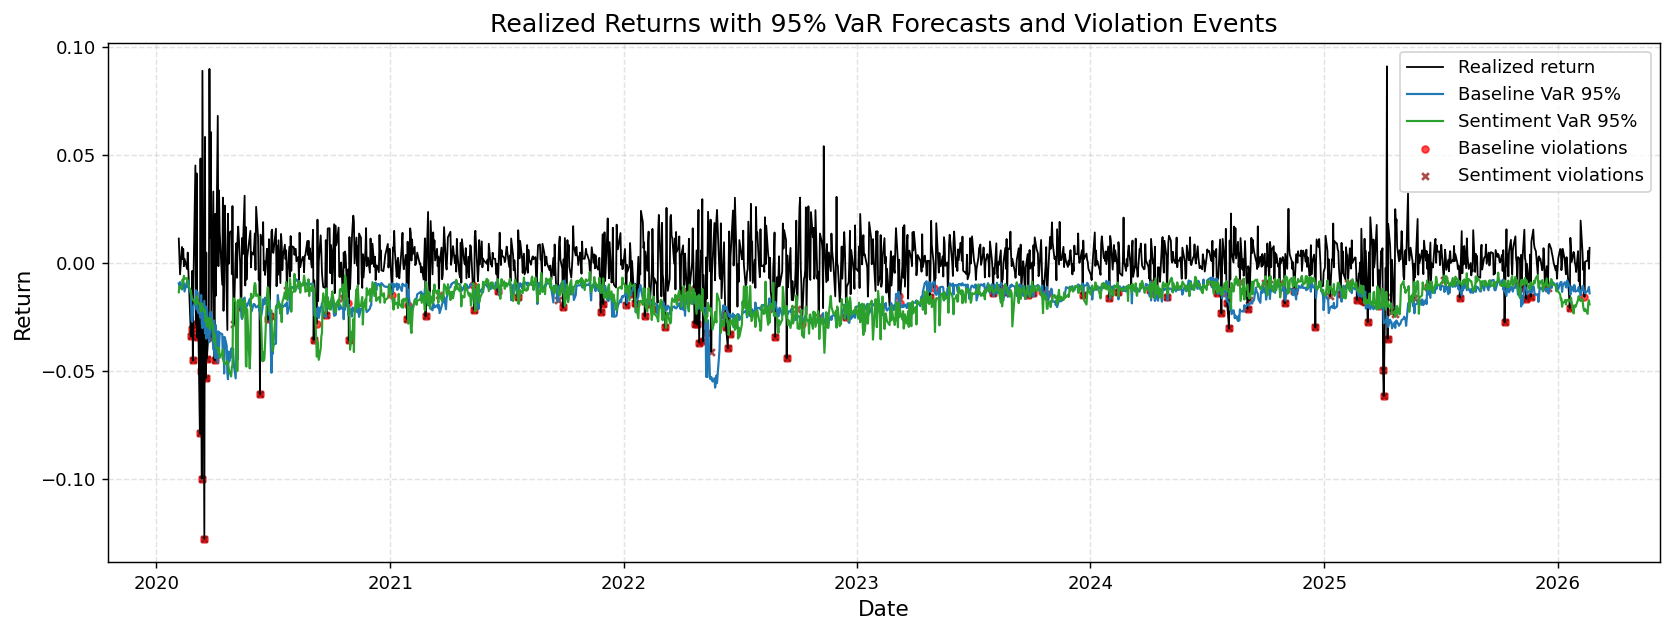

In [6]:
# Plot 1 — Returns with VaR Overlay (95%) and violations
plot_df = plot_df.sort_values("Date").copy()

# Use baseline realized return as primary series (same market return source expected)
plot_df["y_real"] = plot_df["y_real_baseline"]

viol_b = plot_df["violation_95_baseline"].astype(int) == 1
viol_s = plot_df["violation_95_sentiment"].astype(int) == 1

fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(plot_df["Date"], plot_df["y_real"], color="black", linewidth=1.0, label="Realized return")
ax.plot(plot_df["Date"], plot_df["VaR_95_baseline"], color="#1f77b4", linewidth=1.2, label="Baseline VaR 95%")
ax.plot(plot_df["Date"], plot_df["VaR_95_sentiment"], color="#2ca02c", linewidth=1.2, label="Sentiment VaR 95%")

ax.scatter(plot_df.loc[viol_b, "Date"], plot_df.loc[viol_b, "y_real"],
           color="red", s=14, marker="o", alpha=0.7, label="Baseline violations")
ax.scatter(plot_df.loc[viol_s, "Date"], plot_df.loc[viol_s, "y_real"],
           color="darkred", s=14, marker="x", alpha=0.7, label="Sentiment violations")

ax.set_title("Realized Returns with 95% VaR Forecasts and Violation Events")
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend(frameon=True)
plt.tight_layout()
plt.show()


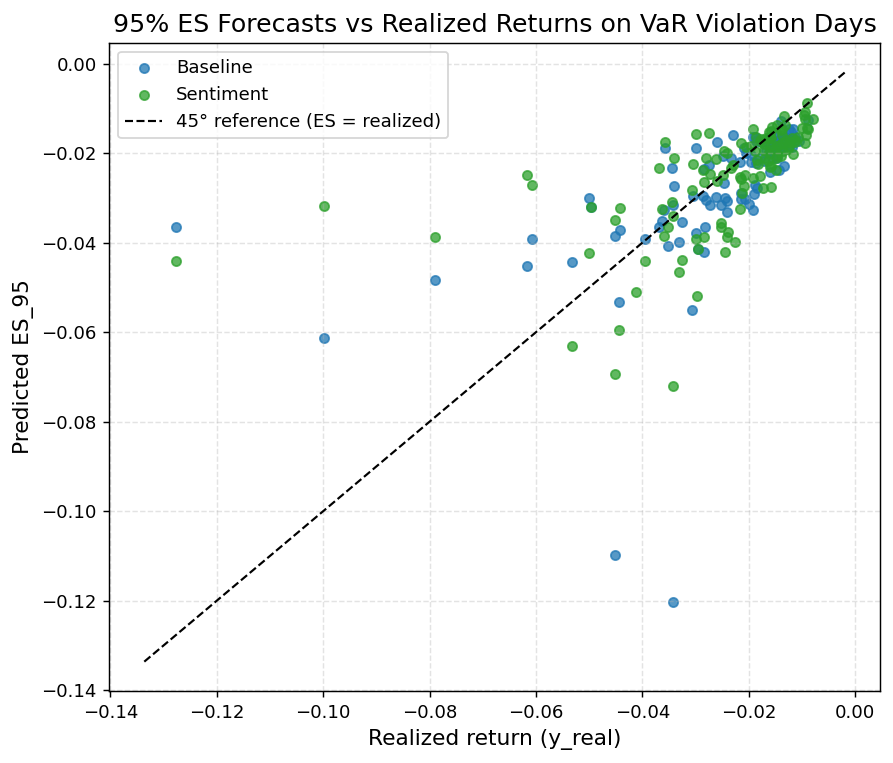

In [7]:
# Plot 2 — ES vs Realized Loss on violation days only (95%)
all_vals = pd.concat([
    tail_b95["y_real"], tail_b95["ES_95"],
    tail_s95["y_real"], tail_s95["ES_95"]
], axis=0).dropna()

vmin, vmax = all_vals.min(), all_vals.max()
pad = (vmax - vmin) * 0.05 if vmax > vmin else 0.001
line_min, line_max = vmin - pad, vmax + pad

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(tail_b95["y_real"], tail_b95["ES_95"], color="#1f77b4", alpha=0.75, s=26, label="Baseline")
ax.scatter(tail_s95["y_real"], tail_s95["ES_95"], color="#2ca02c", alpha=0.75, s=26, label="Sentiment")
ax.plot([line_min, line_max], [line_min, line_max], "k--", linewidth=1.2, label="45° reference (ES = realized)")

ax.set_title("95% ES Forecasts vs Realized Returns on VaR Violation Days")
ax.set_xlabel("Realized return (y_real)")
ax.set_ylabel("Predicted ES_95")
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend(frameon=True)
plt.tight_layout()
plt.show()


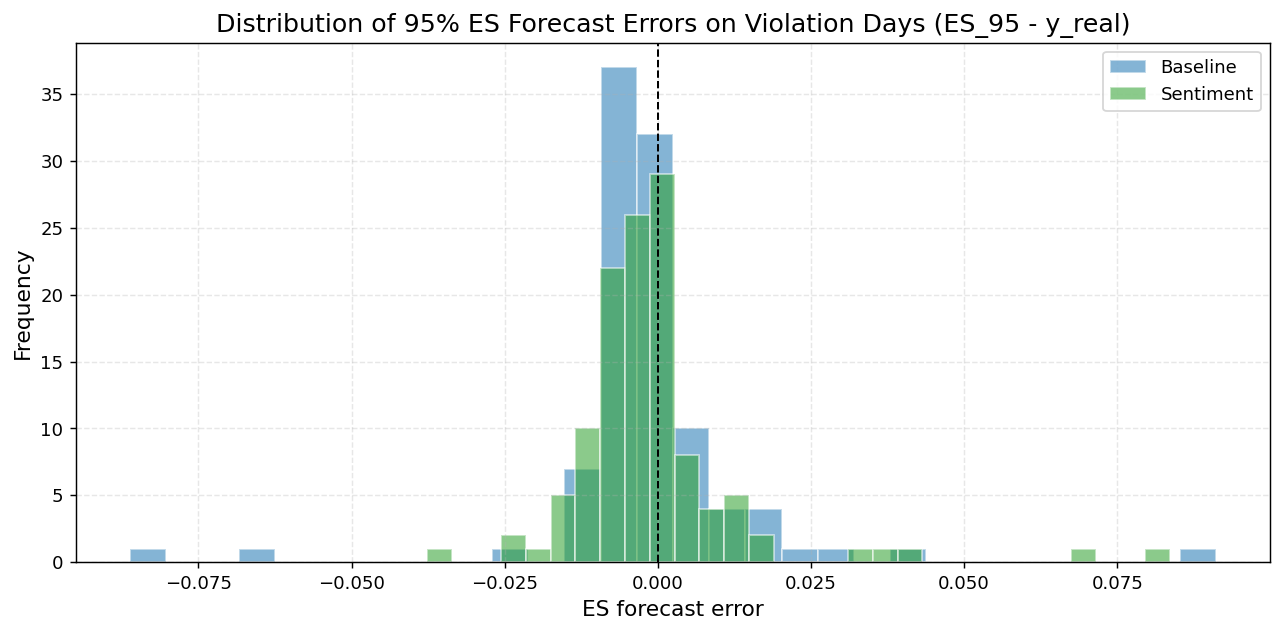

In [8]:
# Plot 3 — Distribution of ES errors (95%)
err_b95 = (tail_b95["ES_95"] - tail_b95["y_real"]).dropna()
err_s95 = (tail_s95["ES_95"] - tail_s95["y_real"]).dropna()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(err_b95, bins=30, alpha=0.55, color="#1f77b4", label="Baseline", edgecolor="white")
ax.hist(err_s95, bins=30, alpha=0.55, color="#2ca02c", label="Sentiment", edgecolor="white")
ax.axvline(0, color="black", linestyle="--", linewidth=1.1)

ax.set_title("Distribution of 95% ES Forecast Errors on Violation Days (ES_95 - y_real)")
ax.set_xlabel("ES forecast error")
ax.set_ylabel("Frequency")
ax.grid(True, linestyle="--", alpha=0.30)
ax.legend(frameon=True)
plt.tight_layout()
plt.show()


In [ ]:
# Plot 4 — 250-day rolling 95% VaR violation rate (Baseline vs Sentiment)
from matplotlib.ticker import PercentFormatter

rolling_src = plot_df.copy()

# 1) Convert Date to datetime and sort
rolling_src["Date"] = pd.to_datetime(rolling_src["Date"], errors="coerce")
rolling_src = rolling_src.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# 2) Violation indicators at 95%
rolling_src["violation_95_baseline"] = (rolling_src["y_real_baseline"] <= rolling_src["VaR_95_baseline"]).astype(int)
rolling_src["violation_95_sentiment"] = (rolling_src["y_real_sentiment"] <= rolling_src["VaR_95_sentiment"]).astype(int)

# 3) 250-day rolling violation rates
window = 250
rolling_src["rolling_rate_baseline"] = rolling_src["violation_95_baseline"].rolling(window=window, min_periods=window).mean()
rolling_src["rolling_rate_sentiment"] = rolling_src["violation_95_sentiment"].rolling(window=window, min_periods=window).mean()

# 4,5,6,7) Plot with expected 5% reference and thesis-style formatting
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    rolling_src["Date"],
    rolling_src["rolling_rate_baseline"],
    color="#1f77b4",
    linewidth=1.8,
    label="Baseline (250-day rolling violation rate)",
)
ax.plot(
    rolling_src["Date"],
    rolling_src["rolling_rate_sentiment"],
    color="#2ca02c",
    linewidth=1.8,
    linestyle="-.",
    label="Sentiment (250-day rolling violation rate)",
)

ax.axhline(
    0.05,
    color="black",
    linestyle="--",
    linewidth=1.3,
    label="Expected violation rate (5%)",
)

ax.set_title("Rolling 250-Day 95% VaR Violation Rate: Baseline vs Sentiment")
ax.set_xlabel("Date")
ax.set_ylabel("Violation Rate")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax.grid(True, linestyle="--", alpha=0.30)
ax.legend(frameon=True, loc="best")

plt.tight_layout()
plt.show()
